# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.252528,False,2.905986
1,-0.350872,False,-0.173224
2,0.841546,True,5.162669
3,-0.581652,False,1.213511
4,-0.327807,False,-1.154535
...,...,...,...
995,-0.653526,False,-1.079113
996,-0.234960,True,4.718533
997,1.412205,True,5.889408
998,-0.189010,False,0.604936


<AxesSubplot: xlabel='v0'>

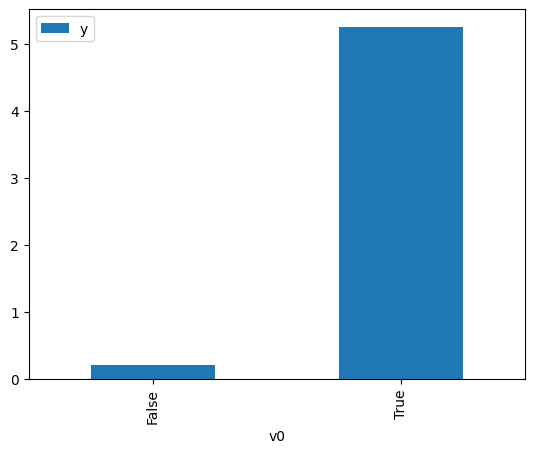

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

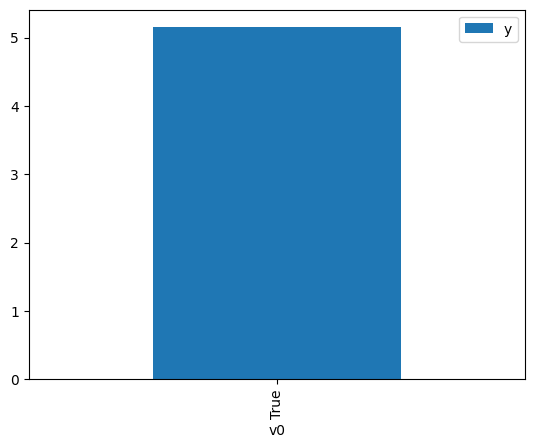

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.242615,False,0.907145,0.916226,1.091433
1,0.007415,False,0.687815,0.509663,1.962083
2,1.561557,False,-0.628148,0.052780,18.946573
3,0.910238,False,0.197795,0.159610,6.265263
4,0.398450,False,1.316079,0.332353,3.008852
...,...,...,...,...,...
995,-0.646152,False,0.242227,0.780598,1.281069
996,0.990254,False,-0.107813,0.140423,7.121336
997,1.064571,False,-0.142569,0.124368,8.040654
998,0.420033,False,1.203509,0.323398,3.092164


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.162952,True,5.837367,0.411102,2.432488
1,1.118816,True,6.044369,0.886334,1.128243
2,0.157350,True,4.851680,0.560609,1.783774
3,-0.693712,True,4.401313,0.204452,4.891131
4,-1.831029,True,6.457631,0.029313,34.114743
...,...,...,...,...,...
995,-0.419714,True,6.218726,0.300939,3.322931
996,-0.711584,True,6.425236,0.199033,5.024290
997,0.177693,True,4.907648,0.570021,1.754323
998,0.298789,True,4.787014,0.624790,1.600539


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              8770.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                        0.00
Time:                        22:24:17   Log-Likelihood:                         -1400.6
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2815.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3209      0.037      8.612      0.000       0.248       0.394
x2             5.0323      0.051     98.116      0.000       4.932       5.133
==============================================================================
Omnibus:                        0.455   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.544
Skew:                           0.023   Prob(JB):                        0.762
Kurtosis:                       2.895   Cond. No.                         2.24
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""